In [2]:
!pip install tensorflow-gpu

from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p x64
!cp gdrive/My\ Drive/x64/*.npy x64/.
!cp gdrive/My\ Drive/*.py .
!ls -l

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 5395780
-rw------- 1 root root       2875 Mar 27 13:32 _dataset_tools.py
drwx------ 3 root root       4096 Mar 27 11:45 gdrive
-rw-r--r-- 1 root root          0 Mar 27 13:13 history
-rw-r--r-- 1 root root     319586 Mar 27 13:19 model.png
-rw------- 1 root root       2398 Mar 27 13:32 _my_tools.py
drwxr-xr-x 2 root root       4096 Mar 27 11:47 __pycache__
drwxr-xr-x 1 root root       4096 Mar  8 17:26 sample_data
drwxr-xr-x 2 root root       4096 Mar 27 13:32 x64
-rw------- 1 root root  920825984 Mar 27 11:45 X_test.npy
-rw------- 1 root root 2762440832 Mar 27 11:46 X_train.npy
-rw------- 1 root root  460413056 Mar 27 11:46 y_test.npy
-rw------- 1 root root 1381220480 Mar 27 11:46 y_train.npy


In [1]:
import tensorflow as tf
from tensorflow import keras
import _my_tools as mt
import numpy as np

X_train, y_train, X_test, y_test = mt.loadData("x64/",'float16',channels_last=True)

print("tf version - ", tf.__version__)

tf version -  1.13.1


In [0]:
from tensorflow.keras.layers import Layer, InputSpec

# It assumes, that we are using channel_last.
class SepConv(Layer):

    def __init__(self, **kwargs):
        super(SepConv, self).__init__(**kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4),InputSpec(ndim=4)]

        self.sess = tf.Session()

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        assert (len(input_shape) == 3)

        self.input_spec = [InputSpec(shape=input_shape[0]), InputSpec(shape=input_shape[1]), InputSpec(shape=input_shape[2])]
        self.checkInput()

    def call(self, x):
        assert isinstance(x, list)
        assert (len(x) == 3)
        
        # Unpack the batch dimension
        output = tf.map_fn(self.l_1, x, dtype=tf.float32)
        
        return output

    def compute_output_shape(self, input_shape):
        assert isinstance(input_shape, list)
        assert (len(input_shape) == 3)

        img, horizontal, vertical = input_shape
        
        return [self.n_b, self.m_out, self.m_out, self.n_channels]

    def checkInput(self):#, img, horizontal, vertical):
        i_shape = self.input_spec[0].shape
        h_shape = self.input_spec[1].shape
        v_shape = self.input_spec[2].shape
    
        self.n_b = i_shape[0] # number of batches
        self.m = i_shape[1] # dimension of image
        self.n_channels = i_shape[3] # number of channels
        self.filter_size = h_shape[3] # size of filter == depth of NN output
        self.m_out = self.m - self.filter_size + 1
        
        assert i_shape[1] == i_shape[2]
        assert h_shape[3] == v_shape[3]
        assert h_shape[1] == h_shape[2] == v_shape[1] == v_shape[2] == self.m_out
    
#     def localSepConv(self, x):
#         img, horizontal, vertical = x
#         output = np.zeros([self.m_out, self.m_out, self.n_channels])
        
#         for row in range(self.m_out):
#             for col in range(self.m_out):
#                 sub_patch = img[row:row + self.filter_size, col:col + self.filter_size, :]
# #                 print(sess.run(tf.shape(sub_patch)))
#                 kernel_h = tf.reshape( horizontal[row,col,:] , [1,self.filter_size,self.n_channels] )
# #                 print(sess.run(kernel_h))
# #                 kernel_v = tf.transpose(vertical[row,col,:])
#                 kernel_v = tf.reshape( vertical[row,col,:] , [self.filter_size,1,self.n_channels] )
# #                 print(sess.run(kernel_v))
# #                 print(sess.run( tf.shape(tf.reduce_sum(sub_patch * kernel_h * kernel_v,[0,1]) )))
#                 output[row,col,:] = tf.reduce_sum(sub_patch * kernel_h * kernel_v,[0,1])#.eval(session=self.sess)
                
#         return tf.convert_to_tensor(output)
    
    # l_1() unpacks the 1st dimension
    # r is list [0,1,...,filter size], we will cut out the subpatch of input image according to this list
    def l_1(self, x):
        img, horizontal, vertical = x
        
        r = tf.convert_to_tensor(list(range(self.m_out)))
        
        output = tf.map_fn(lambda x: self.l_2(img,x), [horizontal,vertical,r], dtype=tf.float32)
        
        return output
        
    # l_2() unpacks the 2nd dimension
    # sub_patch_tmp is sub patch of input image according to 1st dimension
    def l_2(self, img, x):
        horizontal, vertical, i = x

        sub_patch_tmp = img[i:i + self.filter_size,:,:]
        r = tf.convert_to_tensor(list(range(self.m_out)))
        
        output = tf.map_fn(lambda x: self.l_3(sub_patch_tmp,x),[horizontal, vertical,r], dtype=tf.float32)
        
        return output
    
    # sub_patch is sub patch of input image according to 1st and 2nd dimension
    # l_3() performs convolution on sub_patch and kernels obtained from unpacking of input tensors
    def l_3(self, img, x):
        horizontal, vertical, i = x
        
        sub_patch = img[:,i:i + self.filter_size,:]
        kernel_h = tf.reshape(horizontal,[1, self.filter_size, 1])
        kernel_v = tf.reshape(vertical, [self.filter_size, 1, 1])
        
        output = tf.reduce_sum(sub_patch * kernel_h * kernel_v, [0,1])
        
        return output
    
# ------------------------------------------------------------------------------

class padRep(Layer):
    
    def __init__(self, im, depth, **kwargs):
        super(padRep, self).__init__(**kwargs)
        
        self.im = im # image / channel from input, that we want to extract and pad
        self.depth = depth # depth of padding on every side of input

    def build(self, input_shape):
        super(padRep, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        i = 1
        d = self.depth
        res = x[:,:,:,self.im:self.im + 1]
        
        while d > 0 :
            if i <= d :
                res = tf.pad(res, [[0,0],[i,i],[i,i],[0,0]], "SYMMETRIC")
                d -= i
            else:
                res = tf.pad(res, [[0,0],[d,d],[d,d],[0,0]], "SYMMETRIC")
                d -= d
            i *= 2
        
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.depth, input_shape[2] + 2 * self.depth, 1)
      
# ------------------------------------------------------------------------------

def convBlock(in_channels, out_channels, kernel, stride, padding, activation):
    return keras.models.Sequential([
        keras.layers.Conv2D(in_channels, kernel, stride, padding, activation=activation),
        keras.layers.Conv2D(in_channels, kernel, stride, padding, activation=activation),
        keras.layers.Conv2D(out_channels, kernel, stride, padding, activation=activation)
    ], name='convBlock' + str(in_channels) + '_' + str(out_channels))

def upsampleBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation):
    return keras.models.Sequential([
        upsample,
        keras.layers.Conv2D(out_channels, kernel, stride, padding, activation=activation)
    ], name='upsampleBlock' + str(in_channels) + '_' + str(out_channels))

def kernelConvBlock(upsample, in_channels, out_channels, kernel, stride, padding, activation, name=None):
    return keras.models.Sequential([
        keras.layers.Conv2D(in_channels, kernel, stride, padding, activation=activation),
        keras.layers.Conv2D(in_channels, kernel, stride, padding, activation=activation),
        keras.layers.Conv2D(out_channels, kernel, stride, padding, activation=activation),
        upsample,
        keras.layers.Conv2D(out_channels, kernel, stride, padding, activation=activation)
    ], name=name)

def pool(pool_size, padding):
    return keras.layers.AveragePooling2D(pool_size, padding=padding)

In [3]:
KERNEL_SIZE = 31
conv_setup = {
    'kernel' : (3,3),
    'stride' : (1,1),
    'padding' : 'same',
    'activation' : 'relu'
}
pooling_setup = {
    'pool_size' : (2,2),
    'padding' : 'same'
}
upsample_setup = {
    'size' : (2,2),
    'interpolation' : 'bilinear'
}

pooling_layer = keras.layers.AveragePooling2D(**pooling_setup)
upsample_layer = keras.layers.UpSampling2D(**upsample_setup)

# ------------------------------------------------------------------------------

input_img = keras.layers.Input((64,64,2))

# compression

x32 = convBlock(2, 32, **conv_setup)(input_img)
x32_p = pool(**pooling_setup)(x32)
x64 = convBlock(32, 64, **conv_setup)(x32_p)
x64_p = pool(**pooling_setup)(x64)
x128 = convBlock(64, 128, **conv_setup)(x64_p)
x128_p = pool(**pooling_setup)(x128)
x256 = convBlock(128, 256, **conv_setup)(x128_p)
x256_p = pool(**pooling_setup)(x256)
# x512 = convBlock(256, 512, **conv_setup)(x256_p)
# x512_p = pool(**pooling_setup)(x512)

# x = convBlock(512, 512, **conv_setup)(x512_p)

x = convBlock(256, 256, **conv_setup)(x256_p)

# expansion

# x = upsampleBlock(upsample_layer, 512, 512, **conv_setup)(x)
# x = keras.layers.Add()([x,x512])
# x = convBlock(512, 256, **conv_setup)(x)

x = upsampleBlock(upsample_layer, 256, 256, **conv_setup)(x)
x = keras.layers.Add()([x,x256])
x = convBlock(256, 128, **conv_setup)(x)

x = upsampleBlock(upsample_layer, 128, 128, **conv_setup)(x)
x = keras.layers.Add()([x,x128])
x = convBlock(128, 64, **conv_setup)(x)

x = upsampleBlock(upsample_layer, 64, 64, **conv_setup)(x)
x = keras.layers.Add()([x,x64])

# estimation of local convolution kernels

k1h = kernelConvBlock(upsample_layer, 64, KERNEL_SIZE, **conv_setup, name='kernelConvBlock1')(x)
k1v = kernelConvBlock(upsample_layer, 64, KERNEL_SIZE, **conv_setup, name='kernelConvBlock2')(x)
k2h = kernelConvBlock(upsample_layer, 64, KERNEL_SIZE, **conv_setup, name='kernelConvBlock3')(x)
k2v = kernelConvBlock(upsample_layer, 64, KERNEL_SIZE, **conv_setup, name='kernelConvBlock4')(x)

im1 = padRep(0, KERNEL_SIZE//2)(input_img)
im2 = padRep(1, KERNEL_SIZE//2)(input_img)

out1 = SepConv()([im1,k1h,k1v])
out2 = SepConv()([im2,k2h,k2v])

output = keras.layers.Add()([out1,out2])

model = keras.Model(input_img, output)
model.compile(optimizer='adadelta', loss='mean_absolute_error')

# ------------------------------------------------------------------------------

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
convBlock2_32 (Sequential)      (None, 64, 64, 32)   684         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 32, 32, 32)   0           convBlock2_32[0][0]              
__________________________________________________________________________________________________
convBlock32_64 (Sequential)     (None, 32, 32, 64)   36992       average_pooling2d_1[0][0]        
__________________________________________________________________________________________________
average_po

In [0]:
a = model.predict(X_train[0:1])

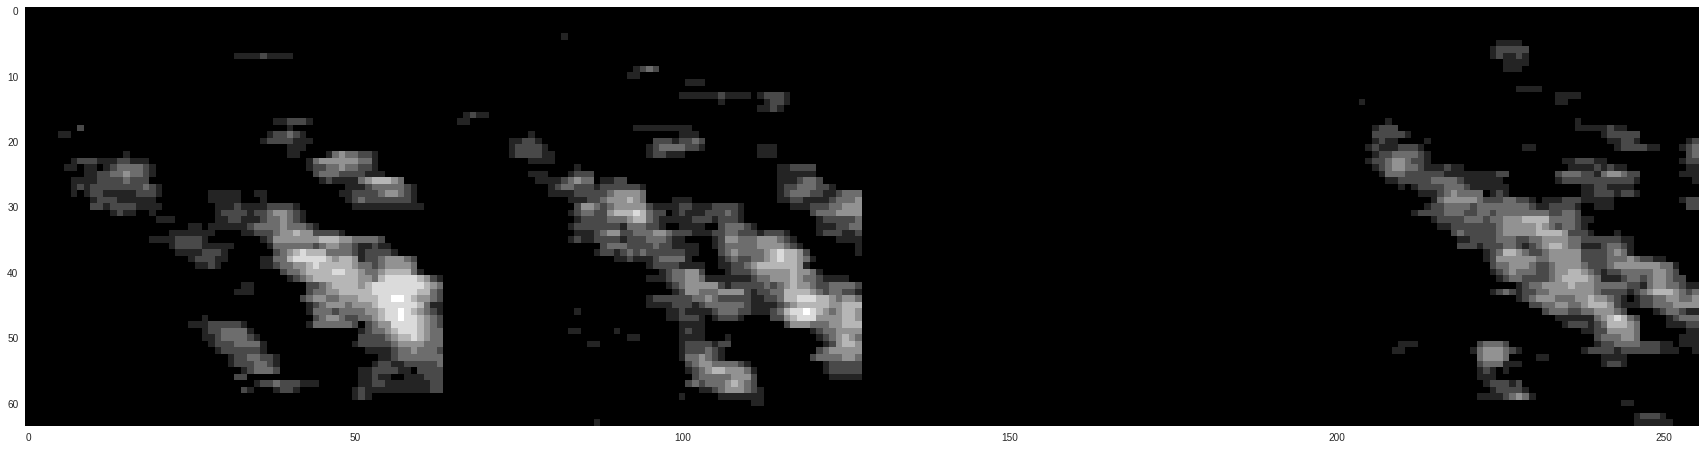

In [6]:
mt.compare(0, X_train, y_train, a)

In [0]:
checkpoint_path = "10/cp"
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True,
                                             verbose=1)
csv_callback = keras.callbacks.CSVLogger('history', separator=',', append=True)

batch_size = 16
num_epoch = 1
#model training
model_log = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,          
          validation_data=(X_test, y_test),
          callbacks = [cp_callback])

Train on 63324 samples, validate on 15831 samples
Instructions for updating:
Use tf.cast instead.


### Le test

In [0]:
L = SepConv()
sess = tf.Session()
L.build([[None,6,6,1],[None,4,4,3],[None,4,4,3]])

A = tf.reshape(tf.constant([[0,0,1,2,3,3],[0,0,1,2,3,3],[1,1,2,3,4,4],[2,2,3.,4,5,5],[3,3,4,5,6,6],[3,3,4,5,6,6]]),[1,6,6,1])
B = tf.reshape(tf.constant([[[0.,1,2],[0.,1,2],[0.,1,2],[0.,1,2]],[[0.,1,2],[0.,1,2],[0.,1,2],[0.,1,2]],[[0.,1,2],[0.,1,2],[0.,1,2],[0.,1,2]],[[0.,1,2],[0.,1,2],[0.,1,2],[0.,1,2]]]),[1,4,4,3])
C = tf.reshape(tf.constant([[[-1.,0,1],[-1.,0,1],[-1.,0,1],[-1.,0,1]],[[-1.,0,1],[-1.,0,1],[-1.,0,1],[-1.,0,1]],[[-1.,0,1],[-1.,0,1],[-1.,0,1],[-1.,0,1]],[[-1.,0,1],[-1.,0,1],[-1.,0,1],[-1.,0,1]]]),[1,4,4,3])


D = L.call([A,B,C])

[[None, 6, 6, 1], [None, 4, 4, 3], [None, 4, 4, 3]]
here -  6


In [0]:
print(sess.run(tf.shape(D)))
print(sess.run(D))

[1 4 4 1]
[[[[3.]
   [3.]
   [3.]
   [3.]]

  [[6.]
   [6.]
   [6.]
   [6.]]

  [[6.]
   [6.]
   [6.]
   [6.]]

  [[3.]
   [3.]
   [3.]
   [3.]]]]


In [0]:
M = np.array([[0,1,2],[2,3,4],[4,5,6]]).reshape([1,3,3,1])
x = model.predict(M)
print(M.reshape([3,3]))
print(x.reshape([9,9]))

[[0 1 2]
 [2 3 4]
 [4 5 6]]
[[0. 0. 0. 0. 1. 2. 2. 2. 2.]
 [0. 0. 0. 0. 1. 2. 2. 2. 2.]
 [0. 0. 0. 0. 1. 2. 2. 2. 2.]
 [0. 0. 0. 0. 1. 2. 2. 2. 2.]
 [2. 2. 2. 2. 3. 4. 4. 4. 4.]
 [4. 4. 4. 4. 5. 6. 6. 6. 6.]
 [4. 4. 4. 4. 5. 6. 6. 6. 6.]
 [4. 4. 4. 4. 5. 6. 6. 6. 6.]
 [4. 4. 4. 4. 5. 6. 6. 6. 6.]]
